In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [10]:
data = pd.read_csv("/Users/lucastucker/REU-2023/archive/mnist_train.csv")
data = np.array(data)
np.random.shuffle(data)

In [11]:
data.shape

(60000, 785)

In [12]:
m = 2000
N = 784
sample = data[:m]
X = sample[:, 1:]
X.shape

(2000, 784)

In [13]:
k = 50 # k nearest neighbors
p = 100 # projection size

In [14]:
def calculate_k_nearest(X):
    k_nearest = np.ones((m, k), dtype=int) * 1
    for id, row in enumerate(X):
        dif = X - row # get pixel-wise differences
        norm_indices = np.argsort(np.linalg.norm(dif, axis = 1))
        k_nearest[id] = norm_indices[1: k + 1]
    return k_nearest

In [15]:
A = np.random.normal(size = (p, N)) # random p projection
X_rand = A.dot(X.T)
X_rand = X_rand.T
X_rand.shape

(2000, 100)

In [16]:
k_nearest_pixel = calculate_k_nearest(X)
k_nearest_random_projection = calculate_k_nearest(X_rand)

In [17]:
def print_img(arr):
    image_matrix = np.reshape(arr, (28, 28))
    plt.figure(figsize=(1,1))
    plt.imshow(image_matrix, cmap='gray')
    plt.axis('off')
    plt.show()

In [18]:
def shared_ratio(k_nearest1, k_nearest2):
    shared_elems_list = []
    for row, row_tilde in zip(k_nearest1, k_nearest2):
        set_1 = set(row)
        set_2 = set(row_tilde)
        shared_elem_count = len(set_1.intersection(set_2))
        shared_elems_list.append(shared_elem_count)
    shared_elems = np.array(shared_elems_list) # row-wise intersection counts
    avg_shared = (1/m) * np.sum(shared_elems)
    return (avg_shared / k)

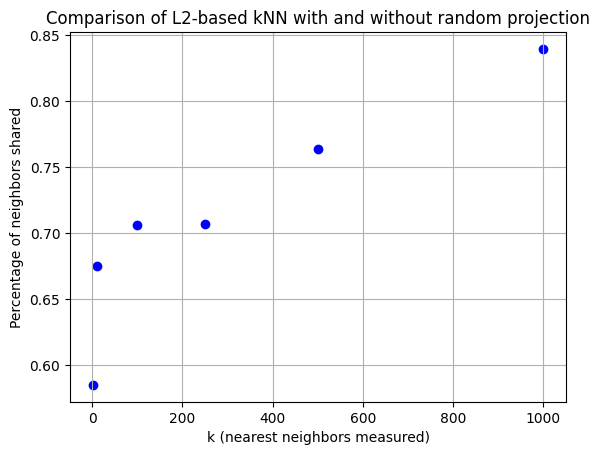

In [19]:
various_k = [1, 10, 100, 250, 500, 1000]
outcomes = [0.585, 0.67545, 0.70608, 0.707156, 0.763373, 0.839542]
# Data from prior trials

plt.scatter(various_k, outcomes, marker = 'o', color = 'b')
plt.xlabel('k (nearest neighbors measured)')
plt.ylabel('Percentage of neighbors shared')
plt.title('Comparison of L2-based kNN with and without random projection')
plt.grid(True)
plt.show()

In [26]:
pca = PCA(n_components=100)
pca.fit(X)
X_pca = pca.transform(X)
X_pca.shape

(2000, 100)

In [28]:
k_nearest_pca = calculate_k_nearest(X_pca)
shared_ratio(k_nearest_pixel, k_nearest_pca) # PCA vs pixel-wise L2 comparison

0.9412600000000001

In [22]:
def cluster_accuracy(k_nearest, img_num):
    correct = sample[img_num][0] # label of the img_num'th image in sample
    sample_cluster = np.zeros((k, 1))
    for index, num in enumerate(k_nearest[img_num]):
        sample_cluster[index] = sample[num][0]
    num_true = np.count_nonzero(sample_cluster == correct)
    return (num_true / k)

In [23]:
indices = np.arange(2000)
# map cluster_accuracy over all k_nearest samples
cluster_accuracy_all = np.vectorize(cluster_accuracy, excluded=['k_nearest'])
accuracies = cluster_accuracy_all(k_nearest=k_nearest_pca, img_num=indices)
# k_nearest_pca can be substituted for other k_nearest

np.average(accuracies)

0.6490999999999999

We will now try to improve upon a basic numpy implementation of PCA. 
First, let's see how long it takes for both algorithms to work:

In [24]:
pca_k = 100 # Pick a pca_k value

In [84]:
def naive_numpy_pca(pca_k, X):
    C = np.cov(X)
    Eig_val, Eig_vec = np.linalg.eig(C)
    Indices = np.argsort(Eig_val)
    print(Indices[:8])
    U_T = Eig_vec.T[Indices, :][:pca_k]
    print(f"U_T.X has shape {U_T.dot(X).shape}")
    return U_T.dot(X)

In [85]:
k_nearest_pca_naive = calculate_k_nearest(naive_numpy_pca(100, X).T)
shared_ratio(k_nearest_pixel, k_nearest_pca_naive) # PCA vs pixel-wise L2 comparison

[619 620 621 626 625 630 629 647]
U_T.X has shape (100, 784)


0.00995